# Modeling of Yelp dataset

In [1]:
random_state = 0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report
from sklearn.utils import resample, parallel_backend
from time import time

In [3]:
from nltk import download
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stepan/snap/jupyter/6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data_dir = '../../data/'
os.listdir(data_dir)

['review.csv']

In [5]:
t = time()
df = pd.read_csv(data_dir + 'review.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 67.85 seconds
with 6,685,900 rows
and 9 columns
-- Column names:
 Index(['stars', 'review_id', 'user_id', 'funny', 'text', 'date', 'useful',
       'cool', 'business_id'],
      dtype='object')


## Drop missing values

In [6]:
mask1 = df['text'].isnull()
df = df[~mask1]
print("Records with no review text were dropped. {0:,} records remain in the DataFrame.".format(len(df)))

Records with no review text were dropped. 6,685,898 records remain in the DataFrame.


## Downsample majority classes

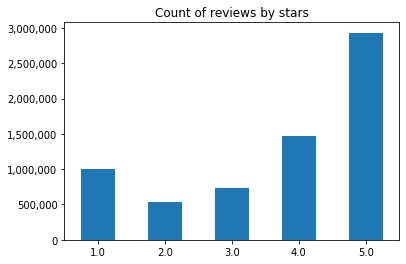

In [7]:
ax = df['stars'].value_counts().sort_index().plot(kind='bar')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
plt.title("Count of reviews by stars");

In [8]:
df1 = df.query("stars == 1.0")
df2 = df.query("stars == 2.0")
df3 = df.query("stars == 3.0")
df4 = df.query("stars == 4.0")
df5 = df.query("stars == 5.0")

In [9]:
print("{0:,}".format(len(df1)))
print("{0:,}".format(len(df2)))
print("{0:,}".format(len(df3)))
print("{0:,}".format(len(df4)))
print("{0:,}".format(len(df5)))

1,002,158
542,394
739,279
1,468,985
2,933,082


In [10]:
df1 = resample(df1, replace=False, n_samples = len(df2), random_state=random_state)
df3 = resample(df3, replace=False, n_samples = len(df2), random_state=random_state)
df4 = resample(df4, replace=False, n_samples = len(df2), random_state=random_state)
df5 = resample(df5, replace=False, n_samples = len(df2), random_state=random_state)

In [11]:
print("{0:,}".format(len(df1)))
print("{0:,}".format(len(df2)))
print("{0:,}".format(len(df3)))
print("{0:,}".format(len(df4)))
print("{0:,}".format(len(df5)))

542,394
542,394
542,394
542,394
542,394


In [12]:
df_downsampled = pd.concat([df1, df2, df3, df4, df5])
print("{0:,} records in the downsampled DataFrame".format(len(df_downsampled)))

2,711,970 records in the downsampled DataFrame


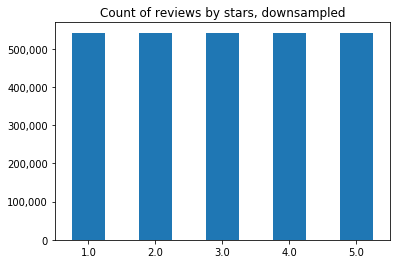

In [13]:
ax = df_downsampled['stars'].value_counts().sort_index().plot(kind='bar')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
plt.title("Count of reviews by stars, downsampled");

## Take a subset of records for grid search

In [14]:
s = df_downsampled.sample(200000, random_state=random_state).copy()
print("{0:,.0f} rows in the subset".format(len(s)))

200,000 rows in the subset


In [15]:
s['stars'].value_counts().sort_index()

1.0    39877
2.0    40373
3.0    39845
4.0    39994
5.0    39911
Name: stars, dtype: int64

## Perform the train-test split

In [16]:
X = s['text']
y = s['stars']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Performed train-test split.
Labels counts in y: [    0 39877 40373 39845 39994 39911]
Labels counts in y_train: [    0 27914 28261 27891 27996 27938]
Labels counts in y_test: [    0 11963 12112 11954 11998 11973]


## Define functions for tokenization / stemming, with examples

In [17]:
def tokenizer(text):
    return text.split()
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [18]:
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(w) for w in text.split()]
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [19]:
snowball = EnglishStemmer()
def tokenizer_snowball(text):
    return [snowball.stem(w) for w in text.split()]
tokenizer_snowball('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thus', 'they', 'run']

In [20]:
lancaster = LancasterStemmer()
def tokenizer_lancaster(text):
    return [lancaster.stem(w) for w in text.split()]
tokenizer_lancaster('runners like running and thus they run')

['run', 'lik', 'run', 'and', 'thu', 'they', 'run']

## Grid search of text vectorization hyperparameters

In [21]:
stop = stopwords.words('english')  # corpus of English stopwords needs to be downloaded from NLTK

In [22]:
gs_results_dir = os.path.join('results', 'gs_results')
if not os.path.exists(gs_results_dir):
    os.makedirs(gs_results_dir)
os.listdir(gs_results_dir)

[]

In [23]:
param_grid = [
    {'vect__ngram_range': [(1,1), (1,2), (1,3)], 
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_snowball, tokenizer_lancaster],
     'vect__binary': [True, False],
     'vect__use_idf': [False],       # model based on raw term frequencies
     'vect__smooth_idf': [False],    # model based on raw term frequencies
     'vect__norm': [None]},          # model based on raw term frequencies
    
    {'vect__ngram_range': [(1,1), (1,2), (1,3)], 
     'vect__stop_words': [stop, None],
     'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_snowball, tokenizer_lancaster],
     'vect__binary': [True, False],
     'vect__use_idf': [True],        # model based on TF-IDF
     'vect__smooth_idf': [True],     # model based on TF-IDF
     'vect__norm': ['l2']}           # model based on TF-IDF
]

In [27]:
param_grid = [
    {'vect__stop_words': [stop, None]}
]

### Logistic regression

In [29]:
GridSearchCV?

In [31]:
t = time()

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

lr_tfidf = Pipeline([('vect', tfidf), 
                     ('clf', LogisticRegression(random_state=random_state, n_jobs=1,
                                                penalty='l2', C=1.0, solver='lbfgs', multi_class='auto'))])
with parallel_backend('loky'):
    gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='f1_macro', cv=5, verbose=1, n_jobs=None)
    gs_lr_tfidf.fit(X_train, y_train)

elapsed = time() - t
print("Grid search completed! Took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [24]:
t = time()

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

multinb_tfidf = Pipeline([('vect', tfidf), ('clf', MultinomialNB())])

gs_multinb_tfidf = GridSearchCV(multinb_tfidf, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=12)

gs_multinb_tfidf.fit(X_train, y_train)

elapsed = time() - t
print("Grid search completed! Took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

### Multinomial Naive Bayes

In [38]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

multinb_tfidf = Pipeline([('vect', bow), ('clf', MultinomialNB())])

multinb_tfidf.fit(X_train, y_train)

y_pred = multinb_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))

Model fit, took 22.02 seconds (0.37 minutes)
              precision    recall  f1-score   support

         1.0       0.60      0.68      0.64     11963
         2.0       0.45      0.44      0.44     12112
         3.0       0.45      0.50      0.47     11954
         4.0       0.50      0.55      0.52     11998
         5.0       0.77      0.53      0.63     11973

    accuracy                           0.54     60000
   macro avg       0.55      0.54      0.54     60000
weighted avg       0.55      0.54      0.54     60000



### Complement Naive Bayes

In [39]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

complnb_tfidf = Pipeline([('vect', bow), ('clf', ComplementNB())])

complnb_tfidf.fit(X_train, y_train)

y_pred = complnb_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))

Model fit, took 22.17 seconds (0.37 minutes)
              precision    recall  f1-score   support

         1.0       0.52      0.81      0.64     11963
         2.0       0.51      0.28      0.36     12112
         3.0       0.46      0.41      0.43     11954
         4.0       0.47      0.55      0.51     11998
         5.0       0.68      0.57      0.62     11973

    accuracy                           0.52     60000
   macro avg       0.53      0.53      0.51     60000
weighted avg       0.53      0.52      0.51     60000



### Logistic Regression

In [8]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

lr_tfidf = Pipeline([('vect', bow), ('clf', LogisticRegression(random_state=random_state, verbose=1,
                                                               solver='lbfgs', multi_class='ovr',
                                                               penalty='l2', C=1.0, n_jobs=-1))])

lr_tfidf.fit(X_train, y_train)

y_pred = lr_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/stepan/snap/jupyter/common/lib/p

Model fit, took 4,454.82 seconds (74.25 minutes)
              precision    recall  f1-score   support

         1.0       0.74      0.85      0.79    300647
         2.0       0.52      0.23      0.32    162718
         3.0       0.53      0.34      0.41    221784
         4.0       0.53      0.42      0.47    440696
         5.0       0.73      0.91      0.81    879925

    accuracy                           0.68   2005770
   macro avg       0.61      0.55      0.56   2005770
weighted avg       0.65      0.68      0.65   2005770



### Linear Support Vector Classifier

In [ ]:
t = time()

bow = CountVectorizer(ngram_range=(1,1), tokenizer=tokenizer)

lsvc_tfidf = Pipeline([('vect', bow), ('clf', LinearSVC(random_state=random_state,
                                                        penalty='l2', C=1.0))])

lsvc_tfidf.fit(X_train, y_train)

y_pred = lsvc_tfidf.predict(X_test)

elapsed = time() - t

print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
print(classification_report(y_test, y_pred))